<a href="https://colab.research.google.com/github/pratik-poudel/datacrunch/blob/main/17th%20April%20Regression%20chain%20with%20crossval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
import gc
# pd.options.display.float_format| = "{:.2f}".format
pd.options.display.max_columns = 500

import sklearn
from sklearn import *
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.utils.testing import all_estimators
from sklearn.base import RegressorMixin
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold, cross_val_score
from sklearn.multioutput import RegressorChain


import requests
import time
from scipy import stats

import lightgbm as lgb
import xgboost as xgb

In [2]:
train_datalink_X = 'https://tournament.datacrunch.com/data/X_train.csv'  
train_datalink_y = 'https://tournament.datacrunch.com/data/y_train.csv'
hackathon_data_link = 'https://tournament.datacrunch.com/data/X_test.csv'

train = pd.read_csv(train_datalink_X)
target = pd.read_csv(train_datalink_y)
test = pd.read_csv(hackathon_data_link)

In [3]:
print(train.shape, test.shape)

(6538, 15) (3436, 15)


In [4]:
train.head()

,Moons,id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13
0,0,0x9818876384b58d3c,0.50,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
1,0,0xf9aeb187b2dad4f,0.50,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0
2,0,0x131db64190c7c8af,0.75,1.0,0.75,0.0,0.0,0.0,0.0,0.5,0.5,1.0,0.75,0.75,1.0
3,0,0xdbcbe7dd2f47b4ea,0.50,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.50,0.75,0.5
4,0,0x580e576eca4dc196,0.75,1.0,0.75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0


In [5]:
target.head()

,target_r,target_g,target_b
0,0.25,0.25,0.25
1,0.00,0.00,0.00
2,0.50,0.50,0.50
3,0.00,0.00,0.00
4,0.75,1.00,0.75


In [6]:
feat= [f for f in train.columns if "Feature" in f]
print(feat)

['Feature_1', 'Feature_2', 'Feature_3', 'Feature_4', 'Feature_5', 'Feature_6', 'Feature_7', 'Feature_8', 'Feature_9', 'Feature_10', 'Feature_11', 'Feature_12', 'Feature_13']


In [7]:
train[feat].corrwith(target.target_r).abs().sort_values()

Feature_2     0.003135
Feature_3     0.008503
Feature_6     0.009482
Feature_7     0.009482
Feature_4     0.009940
Feature_5     0.009940
Feature_11    0.013092
Feature_12    0.014269
Feature_8     0.027604
Feature_9     0.027604
Feature_13    0.037069
Feature_1     0.043522
Feature_10    0.051558
dtype: float64

# Function

>AdaBoostRegressor 0.046 (0.025), (1.226) seconds
>BaggingRegressor 0.036 (0.026), (2.759) seconds
>BayesianRidge 0.060 (0.011), (0.316) seconds
>DecisionTreeRegressor 0.028 (0.016), (0.537) seconds
>ElasticNet nan (nan), (0.137) seconds
>ExtraTreeRegressor 0.015 (0.020), (0.391) seconds
>ExtraTreesRegressor 0.041 (0.019), (12.583) seconds
>GradientBoostingRegressor 0.073 (0.027), (8.775) seconds
>HistGradientBoostingRegressor 0.079 (0.015), (9.581) seconds
>HuberRegressor 0.063 (0.011), (2.423) seconds
>Lars 0.065 (0.010), (0.285) seconds
>Lasso nan (nan), (0.165) seconds
>LassoLars nan (nan), (0.149) seconds
>LassoLarsIC 0.064 (0.011), (0.230) seconds
>LinearRegression 0.063 (0.011), (0.172) seconds
>OrthogonalMatchingPursuit 0.051 (0.006), (0.194) seconds
>PassiveAggressiveRegressor 0.028 (0.032), (0.237) seconds
>RANSACRegressor 0.003 (0.024), (3.121) seconds
>RandomForestRegressor 0.054 (0.023), (13.863) seconds
>Ridge 0.063 (0.011), (0.120) seconds
>SGDRegressor 0.060 (0.017), (0

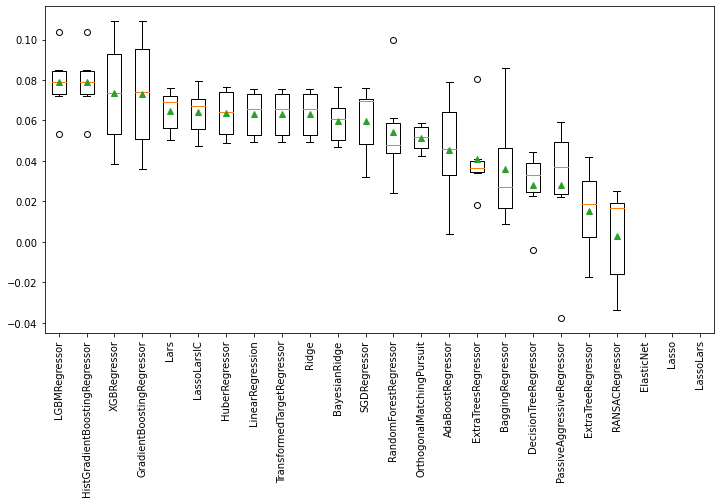

In [67]:
def scorer(y_test, y_pred):
    # print(y_test)
    true_r, pred_r = y_test['target_r'], y_pred[:, 0]
    true_g, pred_g = y_test['target_g'], y_pred[:, 1]
    true_b, pred_b = y_test['target_b'], y_pred[:, 2]

    score_r = (stats.spearmanr(true_r, pred_r))[0]
    score_g = (stats.spearmanr(true_r, pred_r))[0]
    score_b = (stats.spearmanr(true_r, pred_r))[0]
    # print(score_r, score_g, score_b)

    # print(score)
    # print('Score as calculated for the leader board (っಠ‿ಠ)っ {}'.format((score_r + score_g + score_b)/3))
    return (score_r + score_g + score_b)/ 3 


n_split=3
n_repeat=2

my_scorer = make_scorer(scorer, greater_is_better=True)
cv = RepeatedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=60)
regressors = [
                ('AdaBoostRegressor', sklearn.ensemble.AdaBoostRegressor()),
                ('BaggingRegressor', sklearn.ensemble.BaggingRegressor()),
                ('BayesianRidge', sklearn.linear_model.BayesianRidge()),
                ('DecisionTreeRegressor', sklearn.tree.DecisionTreeRegressor()),
                ('ElasticNet', sklearn.linear_model.ElasticNet()),
                ('ExtraTreeRegressor', sklearn.tree.ExtraTreeRegressor()),
                ('ExtraTreesRegressor', sklearn.ensemble.ExtraTreesRegressor()),
                ('GradientBoostingRegressor', sklearn.ensemble.GradientBoostingRegressor()),
                ('HistGradientBoostingRegressor',sklearn.ensemble.HistGradientBoostingRegressor()),
                ('HuberRegressor', sklearn.linear_model.HuberRegressor()),
                ('Lars', sklearn.linear_model.Lars()),
                ('Lasso', sklearn.linear_model.Lasso()),
                ('LassoLars', sklearn.linear_model.LassoLars()),
                ('LassoLarsIC', sklearn.linear_model.LassoLarsIC()),
                ('LinearRegression', sklearn.linear_model.LinearRegression()),
                ('OrthogonalMatchingPursuit',sklearn.linear_model.OrthogonalMatchingPursuit()),
                ('PassiveAggressiveRegressor',sklearn.linear_model.PassiveAggressiveRegressor()),
                ('RANSACRegressor', sklearn.linear_model.RANSACRegressor()),
                ('RandomForestRegressor', sklearn.ensemble.RandomForestRegressor()),
                ('Ridge', sklearn.linear_model.Ridge()),
                ('SGDRegressor', sklearn.linear_model.SGDRegressor()),
                ('TransformedTargetRegressor',sklearn.compose.TransformedTargetRegressor()),
                ("XGBRegressor", xgb.XGBRegressor(objective='reg:squarederror')),
                ("LGBMRegressor", lgb.LGBMRegressor())
                ]

results, names = list(), list()
mean_scores = []
std_scores = []
time_taken_seconds = []
for name, model in regressors:
    if 'random_state' in model.get_params().keys():
        model.set_params(random_state=60)
    if 'n_jobs' in model.get_params().keys():
            model.set_params(n_jobs=-1)

    start = time.time()
    wrapper = RegressorChain(model)
    scores = cross_val_score(wrapper, train[feat], target, scoring=my_scorer, 
                            #  n_jobs=-1, 
                             cv= cv)
    results.append(scores)
    names.append(name)
    mean_scores.append(np.mean(scores))
    std_scores.append(np.std(scores))
    end = time.time()
    time_taken= end-start
    time_taken_seconds.append(np.round(time_taken, 2))
    print('>%s %.3f (%.3f), (%.3f)' % (name, np.mean(scores), np.std(scores), time_taken), "seconds")

df1 = pd.DataFrame(np.column_stack([names, mean_scores, std_scores, time_taken_seconds]), 
                columns=['models', 'mean_score', 'std_score', 'time_taken_seconds'])
df2 = pd.DataFrame(results, columns=["".join('score'+ str(i)) for i in range(n_split*n_repeat) ])
final_df = pd.concat([df1, df2], axis=1)
int_cols = [f for f in final_df.columns if "score" in f]
for i in int_cols:
    final_df[i] = final_df[i].astype('float')

final_df.sort_values('mean_score', ascending=False, inplace=True)

plt.figure(figsize=(12, 6))
# plt.title(target.name)

plt.boxplot(final_df.iloc[:, 4:].values.tolist(), labels=final_df['models'].to_list(), showmeans=True)

plt.xticks(rotation = 90)
plt.show()

In [66]:
0.078768-0.015123	

0.06364500000000001

In [68]:
final_df

,models,mean_score,std_score,time_taken_seconds,score0,score1,score2,score3,score4,score5
23,LGBMRegressor,0.078768,0.015123,1.5,0.072238,0.084995,0.083503,0.074867,0.103531,0.053470
8,HistGradientBoostingRegressor,0.078763,0.015121,9.58,0.072238,0.084969,0.083503,0.074867,0.103531,0.053470
22,XGBRegressor,0.073373,0.025010,2.52,0.079898,0.067629,0.096897,0.048565,0.109041,0.038210
7,GradientBoostingRegressor,0.073149,0.026641,8.77,0.079909,0.068187,0.100620,0.045177,0.108903,0.036097
10,Lars,0.064809,0.009873,0.28,0.050337,0.075960,0.071223,0.066846,0.052430,0.072057
13,LassoLarsIC,0.064145,0.011035,0.23,0.047326,0.079595,0.068968,0.070882,0.052398,0.065698
9,HuberRegressor,0.063485,0.011206,2.42,0.048722,0.070170,0.076680,0.058566,0.051294,0.075478
14,LinearRegression,0.063240,0.010764,0.17,0.049140,0.071980,0.075422,0.059013,0.050756,0.073132
21,TransformedTargetRegressor,0.063240,0.010764,0.32,0.049140,0.071980,0.075422,0.059013,0.050756,0.073132
19,Ridge,0.063239,0.010796,0.12,0.049087,0.071988,0.075449,0.059109,0.050658,0.073144


In [ ]:
!pip install optuna

In [39]:
import optuna

n_split = 3
n_repeat= 2

cv = RepeatedKFold(n_splits=n_split, n_repeats=n_repeat, random_state=60)

N_TRIALS = 200
def objective(trial):    
    params = {
            'boosting_type': 'gbdt',
            # 'objective': 'regression',
            # 'metric': 'rmse',
            'num_leaves': trial.suggest_int('num_leaves', 4, 32),
            'max_depth': trial.suggest_int('max_depth', 4, 32),
            'learning_rate' : trial.suggest_uniform('learning_rate', 0.0001, 0.99),
            'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
            'min_split_gain' : trial.suggest_uniform('min_split_gain', 0, 1),
            'min_child_weight': trial.suggest_uniform('min_child_weight', 1e-3, 1),
            'min_child_samples': trial.suggest_int('min_child_samples',10, 1000),
            'subsample' : trial.suggest_uniform('subsample', 0.5, 1),
            'subsample_freq': trial.suggest_int('subsample_freq', 0, 1),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),

            }

    model = lgb.LGBMRegressor(**params, random_state=60)
    wrapper = RegressorChain(model)

    scores = cross_val_score(wrapper, train[feat], target, scoring=my_scorer, 
                             n_jobs=-1, 
                             cv= cv, 
                             )
    from google.colab import output
    output.clear()
    
    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar= True)
display(study.best_params)
display(study.best_trial.value)

[I 2021-04-17 14:59:50,813] Trial 199 finished with value: 0.07385854176441158 and parameters: {'num_leaves': 6, 'max_depth': 5, 'learning_rate': 0.12751910536039943, 'n_estimators': 969, 'min_split_gain': 0.030755461932072115, 'min_child_weight': 0.519090151885218, 'min_child_samples': 601, 'subsample': 0.7157596503629204, 'subsample_freq': 1, 'reg_alpha': 0.5532984630441795, 'reg_lambda': 1.864628299409072e-05}. Best is trial 121 with value: 0.08308045320079599.



{'learning_rate': 0.16053011092724595,
 'max_depth': 6,
 'min_child_samples': 407,
 'min_child_weight': 0.5302463206344672,
 'min_split_gain': 0.05037683061849242,
 'n_estimators': 993,
 'num_leaves': 8,
 'reg_alpha': 0.17970873738871537,
 'reg_lambda': 9.080436604909377e-05,
 'subsample': 0.7497773758229087,
 'subsample_freq': 1}

0.08308045320079599

In [48]:
params= {
    'learning_rate': 0.16053011092724595,
    'max_depth': 6,
    'min_child_samples': 407,
    'min_child_weight': 0.5302463206344672,
    'min_split_gain': 0.05037683061849242,
    'n_estimators': 993,
    'num_leaves': 8,
    'reg_alpha': 0.17970873738871537,
    'reg_lambda': 9.080436604909377e-05,
    'subsample': 0.7497773758229087,
    'subsample_freq': 1
    }
lgb_model= lgb.LGBMRegressor(random_state=60)
wrapper = RegressorChain(lgb_model)
wrapper.fit(train[feat], target)

RegressorChain(base_estimator=LGBMRegressor(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=60, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=1.0,
                                            subsample_for_bin=200000,
                                   

In [49]:
lgb_model

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=-1,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
              random_state=60, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [50]:
prediction = pd.DataFrame(wrapper.predict(test[feat]), columns=target.columns)

In [65]:
prediction['target_r']

0       0.492917
1       0.583838
2       0.493675
3       0.546684
4       0.397349
          ...   
3431    0.446819
3432    0.509261
3433    0.589833
3434    0.528366
3435    0.282547
Name: target_r, Length: 3436, dtype: float64

In [52]:
API_KEY = "0GIskIC9Rd1I8sMw6nStutbIbMx7AaZzAyNfuMOVAVWgJtNa1IVQHZAD3WPj" # <- HERE

r = requests.post("https://tournament.datacrunch.com/api/submission",
    files = {
        "file": ("x", prediction.to_csv().encode('ascii'))
    },
    data = {
        "apiKey": API_KEY
    },
)

if r.status_code == 200:
    print("Submission submitted :)")
elif r.status_code == 423:
    print("ERR: Submissions are close")
    print("You can only submit during rounds eg: Friday 7pm GMT+1 to Sunday midnight GMT+1.")
    print("Or the server is currently crunching the submitted files, please wait some time before retrying.")
elif r.status_code == 422:
    print("ERR: API Key is missing or empty")
    print("Did you forget to fill the API_KEY variable?")
elif r.status_code == 404:
    print("ERR: Unknown API Key")
    print("You should check that the provided API key is valid and is the same as the one you've received by email.")
elif r.status_code == 400:
    print("ERR: The file must not be empty")
    print("You have send a empty file.")
elif r.status_code == 401:
    print("ERR: Your email hasn't been verified")
    print("Please verify your email or contact a cruncher.")
elif r.status_code == 429:
    print("ERR: Too many submissions")
else:
    print("ERR: Server returned: " + str(r.status_code))
    print("Ouch! It seems that we were not expecting this kind of result from the server, if the probleme persist, contact a cruncher.")

Submission submitted :)


In [53]:
from sklearn.model_selection import  cross_val_predict

TypeError: ignored

In [61]:
train

,Moons,id,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,Feature_9,Feature_10,Feature_11,Feature_12,Feature_13
0,0,0x9818876384b58d3c,0.50,1.00,0.75,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
1,0,0xf9aeb187b2dad4f,0.50,1.00,0.75,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,0x131db64190c7c8af,0.75,1.00,0.75,0.0,0.0,0.00,0.00,0.50,0.50,1.00,0.75,0.75,1.00
3,0,0xdbcbe7dd2f47b4ea,0.50,1.00,0.75,0.0,0.0,0.00,0.00,0.00,0.00,0.50,0.50,0.75,0.50
4,0,0x580e576eca4dc196,0.75,1.00,0.75,0.0,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6533,13,0xee1509f813ae5a29,0.25,0.50,0.50,1.0,1.0,0.75,0.75,0.75,0.75,0.00,0.00,0.00,0.00
6534,13,0x5be7f5f0950653aa,0.00,0.25,0.25,1.0,1.0,0.25,0.25,0.00,0.00,0.00,0.00,0.00,0.00
6535,13,0x69cf43587a77375b,0.50,0.50,0.50,1.0,1.0,1.00,1.00,1.00,1.00,0.25,0.50,0.75,0.50
6536,13,0xd3618b1bcfac1137,0.25,0.75,1.00,1.0,1.0,1.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00
